### This code visualizes the evolution of various quantities in the FRB package (https://github.com/FRBs/FRB), and compares two versions: one with the SFR computed in Gupta et al. (2025) and one with SFR from Madau & Dickinson (2014).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmos
from frb.dm import igm
from frb.dm import igm_old
import scipy.integrate as integrate
import pandas as pd

c:\Users\Om\Box\FRB Research\frb-cosmic-evol\frb\halos\hmf.py:51: UserWarning: hmf_emulator not imported.  Hope you are not intending to use the hmf.py module..
  warnings.warn("hmf_emulator not imported.  Hope you are not intending to use the hmf.py module..")


In [2]:
sol_rad = 6.957e10 #cm
c = 299792458 * 100 #cm/s
parsec = 3.08568e18 #cm
jansky = 1e-23

In [3]:
def madaumod_sfr(z):
    """
    Returns the star formation rate density at redshift z as determined by maximum likelihood estimation
    of Madau and Dickinson (2014) data (+ 1 Finkelstein and Bagley 2022 data point at z=3) between 0 < z < 4
    """
    return 0.0152 * (1+z)**2.732 / (1 + ((1+z)/3.004)**6.240)   # M_sun yr^-1 Mpc^-3

def omg24_sfr(z):
    """
    Returns the star formation rate density at redshift z as determined for this paper
    valid between 4 <= z < 14.
    """
    return 10**(-0.2571*z - 0.2749)

def smd(z, sfr_func):
    '''
    Returns the stellar mass density profile determined at redshift z using Eq. (2) of 
    Madau and Dickinson (2014) and using R = 0.27 so as to fit the observed data.
    '''
    R = 0.27
    def integrand(z):
        return sfr_func(z) / cosmos.H(z).to("/yr").value / (1+z)
    smd = np.zeros_like(z)
    for i in range(z.shape[0]):
        smd[i] = integrate.quad(integrand, z[i], np.inf)[0]
    return (1-R) * smd

z = np.concatenate(([0], np.arange(0.005,14, 0.01)))

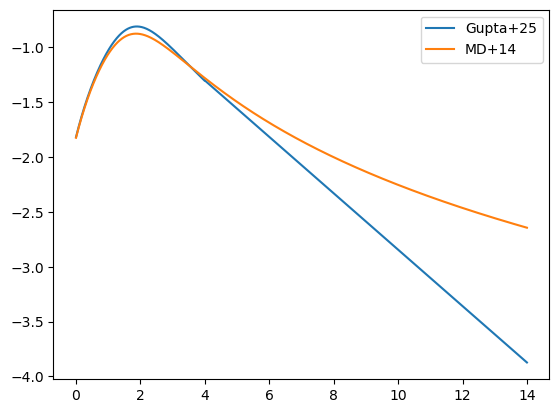

In [4]:
### Plot the star formation rate density
rho_sfr = igm.avg_rhoSFR(z)
r1 = igm_old.avg_rhoSFR(z)
plt.plot(z, np.log10(rho_sfr.value), label="Gupta+25")
plt.plot(z, np.log10(r1.value), label="MD+14")
plt.legend()
plt.show()

### Create a stellar-mass evolution file which uses the star formation rate at high redshift computed in Gupta et al. (2025). The output is designed to be used with the FRB package by Xavier Prochaska and others (https://github.com/FRBs/FRB)

In [5]:
from astropy.io import ascii
rho_smd = np.concatenate((smd(z[:401], madaumod_sfr), smd(z[401:], omg24_sfr)))
dictry = {'z':z, 't_Gyr':cosmos.age(z).value, 'rho_Mstar':rho_smd}
# df = pd.DataFrame(dictry)
# df.to_csv("stellarmass.csv", index=False)

ascii.write(dictry, "files/stellarmass.dat", formats={'z':'%.4f', 't_Gyr':'%.4e', 'rho_Mstar':'%.4e'}, overwrite=True)

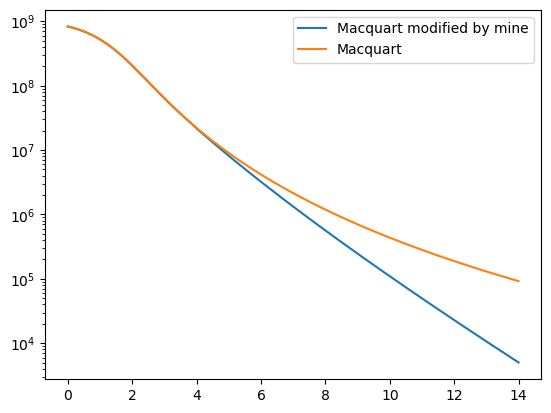

In [5]:
### Plot the stellar mass density
rho_mstar = igm.avg_rhoMstar(z, remnants=True)
rm1 = igm_old.avg_rhoMstar(z, remnants=True)
# plt.plot(z, rho_smd, label="Mine")
plt.plot(z, rho_mstar, label="Macquart modified by mine")
plt.plot(z, rm1, label="Macquart")
plt.yscale('log')
plt.legend()
plt.show()

(1.0, 14.0)

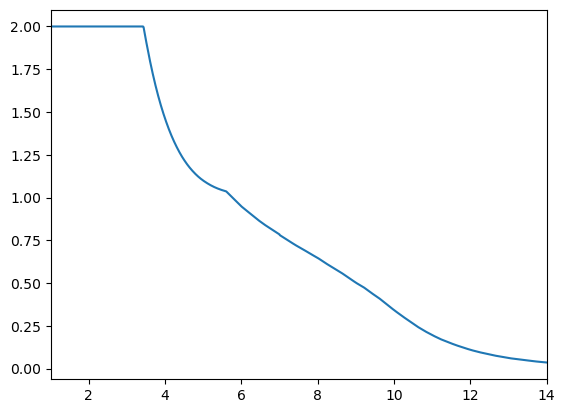

In [6]:
## Plot the average He electron number contribution He nucleus
henum = igm.average_He_nume(z)
plt.plot(z, henum)
plt.xlim([1,14])

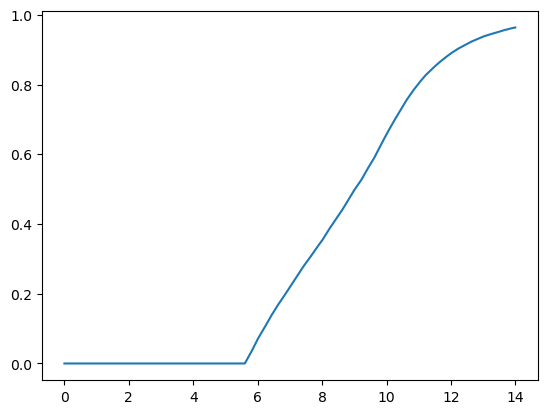

In [7]:
## Plot the evolution of f_HI
hnum = igm.average_fHI(z)
plt.plot(z, hnum)

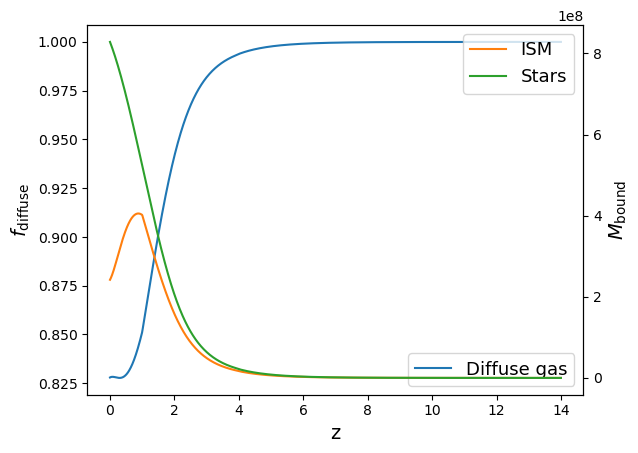

In [18]:
## Compare the evolution of the diffuse gas fraction with the ISM and stellar mass

f_d = igm.f_diffuse(z)
m_ism = igm.avg_rhoISM(z)
m_star = igm.avg_rhoMstar(z)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(z, f_d, label="Diffuse gas")
ax2.plot(z, m_ism, label="ISM", color='C1')
ax2.plot(z, m_star, label="Stars", color='C2')
ax1.set_xlabel("z", fontsize=14)
ax1.set_ylabel(r"$f_{\rm diffuse}$", fontsize=14)
ax2.set_ylabel(r"$M_{\rm bound}$", fontsize=14)
ax1.legend(fontsize=13)
ax2.legend(fontsize=13)
plt.show()

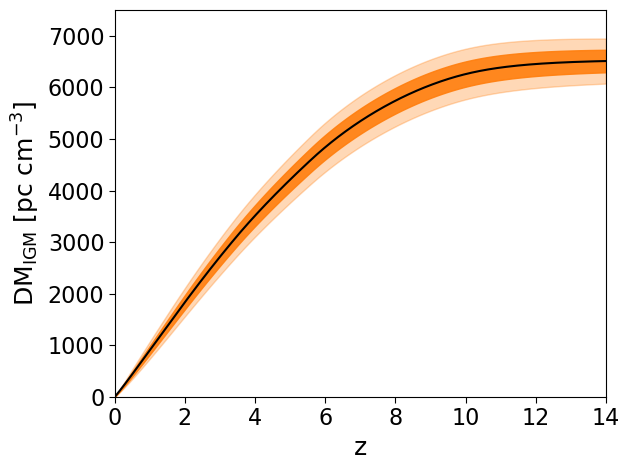

In [20]:
def sigmaDM_KL19(z, DM_igm):
    return 0.13 * DM_igm/np.sqrt(1+z)

dm_cosmic, zeval = igm.average_DM(14, cumul=True)
dm_cosmic = dm_cosmic.value
hi = dm_cosmic + sigmaDM_KL19(zeval, dm_cosmic)
lo = dm_cosmic - sigmaDM_KL19(zeval, dm_cosmic)
hi1 = dm_cosmic + 2*sigmaDM_KL19(zeval, dm_cosmic)
lo1 = dm_cosmic - 2*sigmaDM_KL19(zeval, dm_cosmic)
fig, ax = plt.subplots(1,1)
ax.plot(zeval, dm_cosmic, color='k')
ax.fill_between(zeval, lo, hi, color='C1', alpha=0.9)
ax.fill_between(zeval, lo1, hi1, color='C1', alpha=0.3)
ax.set_ylim([0,7500])
ax.set_xlim([0,14])
ax.set_ylabel(r"DM$_{\rm IGM}$ [pc cm$^{-3}$]", fontsize=18)
ax.set_xlabel("z", fontsize=18)
ax.tick_params(axis='both', which='major', length=4, labelsize=16)
# ax.tick_params(axis='both', which='minor', length=4)
plt.tight_layout()
plt.show()